In [26]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### класс объекта

In [3]:
class Object:
    def __init__ (self, point):
        self.point = point
        self.core_distance = None
        self.rel_distance = None
        self.processed = False
        self.cluster_id = None
        return
    def get_length (self, EPS):
        if self.rel_distance != None:
            return self.rel_distance
        return EPS

In [4]:
def init_objects (X):
    """
    инициализация списка объектов
    """
    ret_list = []
    for i in X:
        obj = Object(i)
        ret_list.append(obj)
    return ret_list
def get_cluster_numbers_and_points(obj_list):
    ret_clusters = []
    ret_points = []
    for obj in obj_list:
        ret_clusters.append (obj.cluster_id)
        ret_points.append (obj.point)
    return ret_clusters, np.array (ret_points)

#### Дополнительные функции для удобстваработы с данными

In [5]:
def get_neighbors (point, eps, list_of_points):
    ret_list = []
    for x in list_of_points:
        if x != point and (np.linalg.norm (point.point - x.point) < eps):
            ret_list.append (x)
    return ret_list
def get_core_distance (point, neighbors, min_pts):
    if (point.core_distance != None):
        return point.core_distance
    if len(neighbors) >= min_pts:
        nearest_point = min(neighbors, key=lambda i: np.linalg.norm (i.point - point.point))
        point.core_distance = np.linalg.norm (nearest_point.point - point.point)
    else:
        point.core_distance = None
    return point.core_distance
# def get_next_point_for_process (points_list):
#     try:
#         return next(point for point in points_list if point.processed == False)
#     except:
#         return False

### главный функционал

In [6]:
#UPDATE FUNCTION!

def update (neighbors, point, Seeds, min_pts, epsilon):
    #z_point = get_next_point_for_process (neighbors)
    for z_point in neighbors:
        if z_point.processed == False:
            new_reach_dist = max(point.core_distance, np.linalg.norm (point.point - z_point.point))
            # z is not in Seeds
            if (z_point.rel_distance == None):
                z_point.rel_distance = new_reach_dist
                Seeds.append(z_point)
            # z in Seeds, check for improvement
            else:              
                if (new_reach_dist < z_point.rel_distance):
                    z_point.rel_distance = new_reach_dist

In [7]:
#construct of clusters

def do_clustering (points_list, eps, min_pts):
    cluster_id = 0 # 0 is for noise
    for point in points_list:
        if point.rel_distance == None or point.rel_distance > eps:
            if point.core_distance != None and point.core_distance < eps:
                cluster_id += 1
                point.cluster_id = cluster_id
            else:
                point.cluster_id = 0
        else:
            point.cluster_id = cluster_id

In [63]:
#Main class

from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):
        """
        epsilon=1 is for epsioln
        min_pts=5 is for nearest points count
        """
        self.epsilon = kwargs.get('epsilon',1)
        self.min_pts = kwargs.get('min_pts',5)
        #self.epsilon_res = kwargs.get ('epsilon_res', 1)
        return
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """                
        self.objects_list = init_objects(x)
        self.ret_list = []
#         point = get_next_point_for_process (self.objects_list)
        for point in self.objects_list:
            if point.processed == False:
                neighbors = get_neighbors (point, self.epsilon, self.objects_list)
                core_distance = get_core_distance (point, neighbors, self.min_pts)
                point.processed = True
                self.ret_list.append (point)
                if core_distance != None:
                    Seeds = []
                    update(neighbors, point, Seeds, self.epsilon, self.min_pts)
                    while Seeds:
                        Seeds.sort(key=lambda n: n.rel_distance)
                        z = Seeds.pop(0)
                        z_neighbors = get_neighbors (z, self.epsilon, self.objects_list)
                        z.processed = True
                        self.ret_list.append (z)
                        if (get_core_distance (z, z_neighbors, self.min_pts) != None):
                            update(z_neighbors, z, Seeds, self.epsilon, self.min_pts)
        return self
    
    def predict(self, x, n_eps=None):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        if n_eps != None:
            do_clustering (self.ret_list, n_eps, self.min_pts)
        else:
            do_clustering (self.ret_list, self.epsilon, self.min_pts)
        clusters, x_points = get_cluster_numbers_and_points (self.objects_list)
        return clusters, x_points
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

# Функционал закончен

In [74]:
X_try, y_try = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
cl = Clustering (epsilon=200, min_pts=199)
result, x_p = cl.fit_predict (X_try)

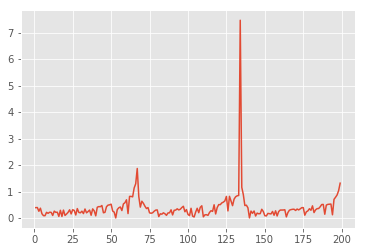

In [75]:
rel_distances = []
for temp_1 in cl.ret_list:
    rel_distances.append (temp_1.rel_distance)
#print rel_distances
pl.plot (rel_distances)

0.752102078217


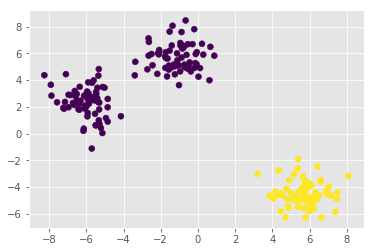

In [79]:
result, x_p = cl.predict (X_try, n_eps=6)
pl.scatter(x_p[:, 0], x_p[:, 1], c=result)
print silhouette_score (x_p, result)

## Ирисы

In [21]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

iris_cl = Clustering (epsilon=20, min_pts=10)
iris_result, iris_x = iris_cl.fit_predict (x_iris)

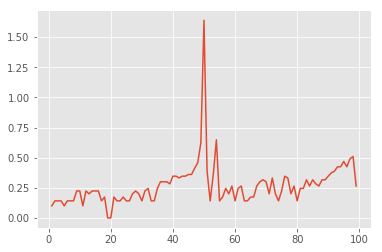

In [69]:
rel_distances = []
for temp_1 in iris_cl.ret_list:
    rel_distances.append (temp_1.rel_distance)
#print rel_distances
pl.plot (rel_distances)

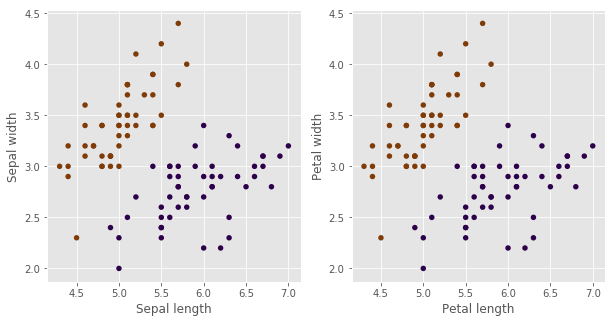

In [27]:
iris_result, iris_x = iris_cl.predict (x_iris, 1)

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(iris_x[:, 0], iris_x[:, 1], c=iris_result, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [25]:
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, iris_result)

Adjusted Rand index for iris is: 1.00


In [45]:
data_df = pd.read_csv("hw_1_result_data.csv", sep=";", header=0, encoding='utf-8')
data_df.head()

,Unnamed: 0,address,checkins,city,country,created,icon,latitude,longitude,pid,title,type,updated
0,0,Мячковский б-р 3а,435,1,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,55.657941,37.751574,1,Baila Baila,4,1.487519e+09
1,1,Дачная 2а,14,123,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,53.202017,50.141377,2,Lust,4,1.483478e+09
2,2,Лени Голикова 29,8,2,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,59.843376,30.231480,3,Тайфун,4,1.486398e+09
3,3,Героев Танкограда 63,8,158,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,55.174954,61.451611,4,Hollywood,4,1.470157e+09
4,4,Мусы Джалиля 14К1,38,99,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,54.860834,83.091932,5,Барабас,4,1.488720e+09


In [57]:
krit_x = data_df[['latitude', 'longitude']].values[:1000,]
print krit_x
print krit_x.shape

[[ 55.657941  37.751574]
 [ 53.202017  50.141377]
 [ 59.843376  30.23148 ]
 ..., 
 [ 59.868397  30.46444 ]
 [ 45.101865  38.983545]
 [ 55.821285  49.09337 ]]
(1000, 2)


# Критерий качества

In [92]:
def quality(x, y):
    """
    Implement quality criterion of your choice
    """
    return silhouette_score (iris_x, iris_result)
#     np_y = np.array (y)
#     max_len = np.zeros (len(set(y)))
#     min_len = np.ones (len(set(y)))
#     for i, val in enumerate(set(y)):
#         for p in x[np_y==val]:
#             for t in x[np_y==val]:
#                 if (np.linalg.norm(p - t) > max_len[i]):
#                     max_len[i] = np.linalg.norm(p - t)
#                 if (np.linalg.norm(p - t) < min_len[i]):
#                     min_len[i] = np.linalg.norm(p - t)
#     return max(max_len) / min (min_len)

In [62]:
krit_cl = Clustering(epsilon=50, min_pts=20)
krit_y, krit_x = krit_cl.fit_predict(krit_x)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
10.0
10.1
10.2
10.3
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.2
11.3
11.4
11.5
11.6
11.7
11.8
11.9
12.0
12.1
12.2
12.3
12.4
12.5
12.6
12.7
12.8
12.9
13.0
13.1
13.2
13.3
13.4
13.5
13.6
13.7
13.8
13.9
14.0
14.1
14.2
14.3
14.4
14.5
14.6
14.7
14.8
14.9
15.0
15.1
15.2
15.3
15.4
15.5
15.6
15.7
15.8
15.9
16.0
16.1
16.2
16.3
16.4
16.5
16.6
16.7
16.8
16.9
17.0
17.1
17.2
17.3
17.4
17.5
17.6
17.7
17.8
17.9
18.0
18.1
18.2
18.3
18.4
18.5
18.6
18.7
18.8
18.9
19.0
19.1
19.2
19.3
19.4
19.5
19.6
19.7
19.8
19.9
20.0
20.1
20.2
20.3
20.4
20.5
20.6
20.7
20.8
20.9
21.0
21.1
21.2
21.3
21.4
21.5
21.6
21.7
21.8
21.9


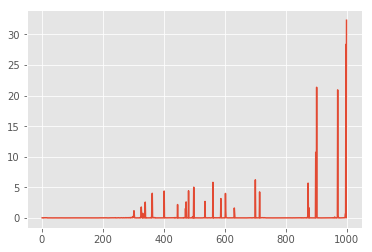

In [64]:
rel_distances = []
for temp_1 in krit_cl.ret_list:
    rel_distances.append (temp_1.rel_distance)
#print rel_distances
pl.plot (rel_distances)

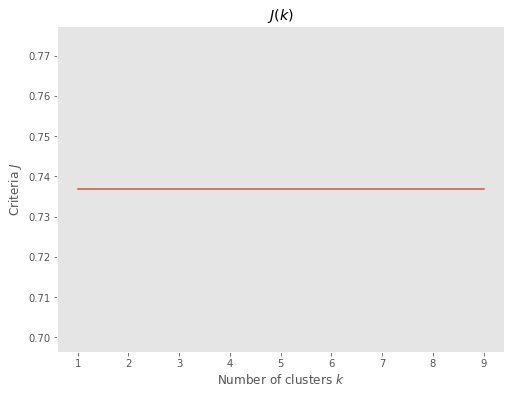

In [99]:
ks = np.arange(1, 10, 1)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    #krit_cl = Clustering(epsilon=5000, min_pts=k)
    #krit_y, krit_x = krit_cl.fit_predict(x)
    krit_y, krit_x = krit_cl.predict (krit_x, n_eps=k)
    criteria[i] = quality(krit_x, krit_y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

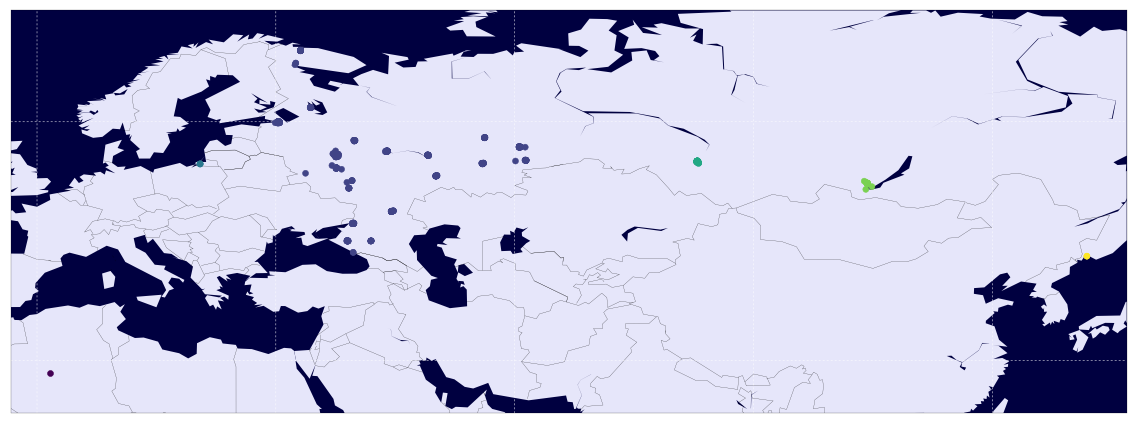

In [100]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(krit_x[:, 0]) - 5, urcrnrlat=max(krit_x[:, 0]) + 5, llcrnrlon=min(krit_x[:, 1]) - 5, urcrnrlon=max(krit_x[:, 1]) + 5, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(krit_x[:, 1], krit_x[:,0], c=krit_y, zorder=10)
    
pl.show()

In [109]:
mos_min_lat, mos_min_lon = 55.570444, 37.271512
mos_max_lat, mos_max_lon = 55.936177, 37.893743


In [110]:
data_moscow = data_df[data_df.latitude.between(mos_min_lat, mos_max_lat) &
                   data_df.longitude.between(mos_min_lon, mos_max_lon)]

In [113]:
mos_krit_x = data_moscow[['latitude', 'longitude']].values[:1000,]

In [114]:
mos_krit_cl = Clustering(epsilon=10, min_pts=20)
mos_krit_y, mos_krit_x = mos_krit_cl.fit_predict(mos_krit_x)

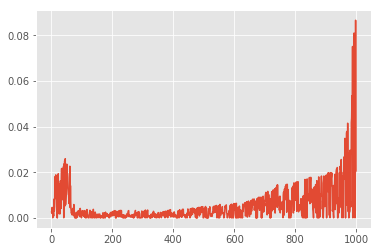

In [115]:
rel_distances = []
for temp_1 in mos_krit_cl.ret_list:
    rel_distances.append (temp_1.rel_distance)
#print rel_distances
pl.plot (rel_distances)

In [124]:
mos_krit_y, mos_krit_x = mos_krit_cl.predict (mos_krit_x, 0.006)

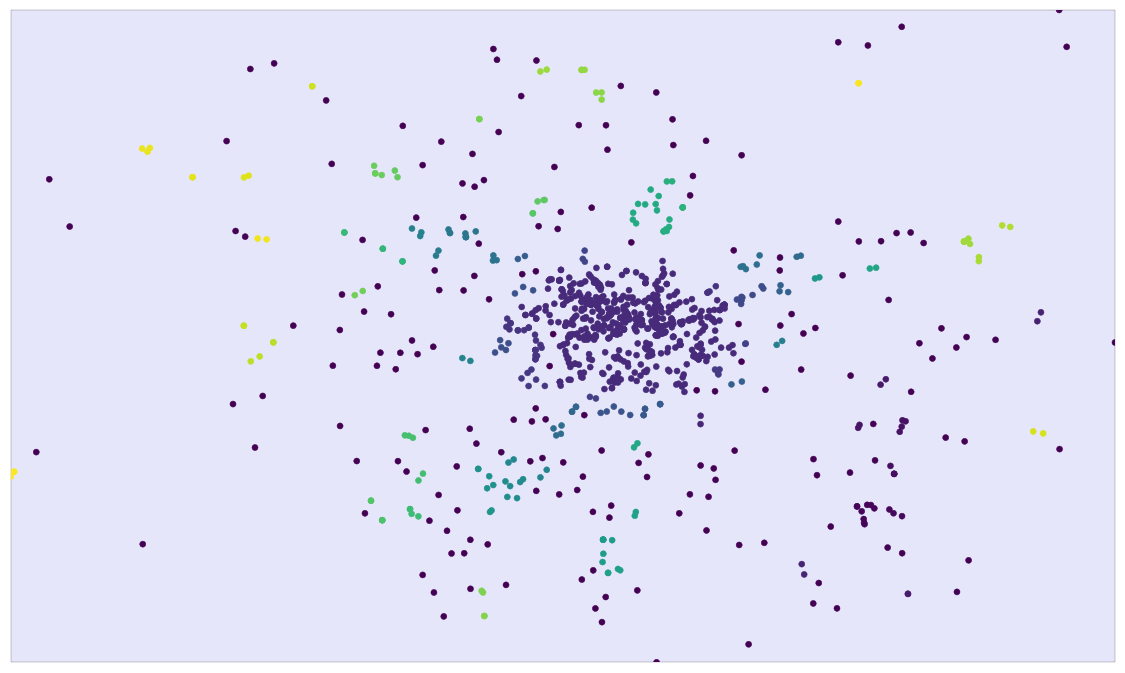

In [125]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(mos_krit_x[:, 0]), urcrnrlat=max(mos_krit_x[:, 0]), llcrnrlon=min(mos_krit_x[:, 1]), urcrnrlon=max(mos_krit_x[:, 1]), resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(mos_krit_x[:, 1], mos_krit_x[:,0], c=mos_krit_y, zorder=10)
    
pl.show()

In [126]:
pit_min_lat, pit_min_lon = 59.763349, 30.038971
pit_max_lat, pit_max_lon = 60.137102, 30.537196


In [127]:
data_piter = data_df[data_df.latitude.between(pit_min_lat, pit_max_lat) &
                   data_df.longitude.between(pit_min_lon, pit_max_lon)]

In [128]:
pit_krit_x = data_piter[['latitude', 'longitude']].values[:1000,]

In [129]:
pit_krit_cl = Clustering(epsilon=10, min_pts=20)
pit_krit_y, pit_krit_x = pit_krit_cl.fit_predict(pit_krit_x)

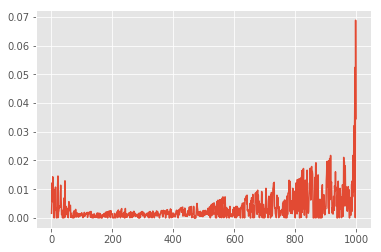

In [130]:
rel_distances = []
for temp_1 in pit_krit_cl.ret_list:
    rel_distances.append (temp_1.rel_distance)
#print rel_distances
pl.plot (rel_distances)

In [138]:
pit_krit_y, pit_krit_x = pit_krit_cl.predict (pit_krit_x, 0.0075)

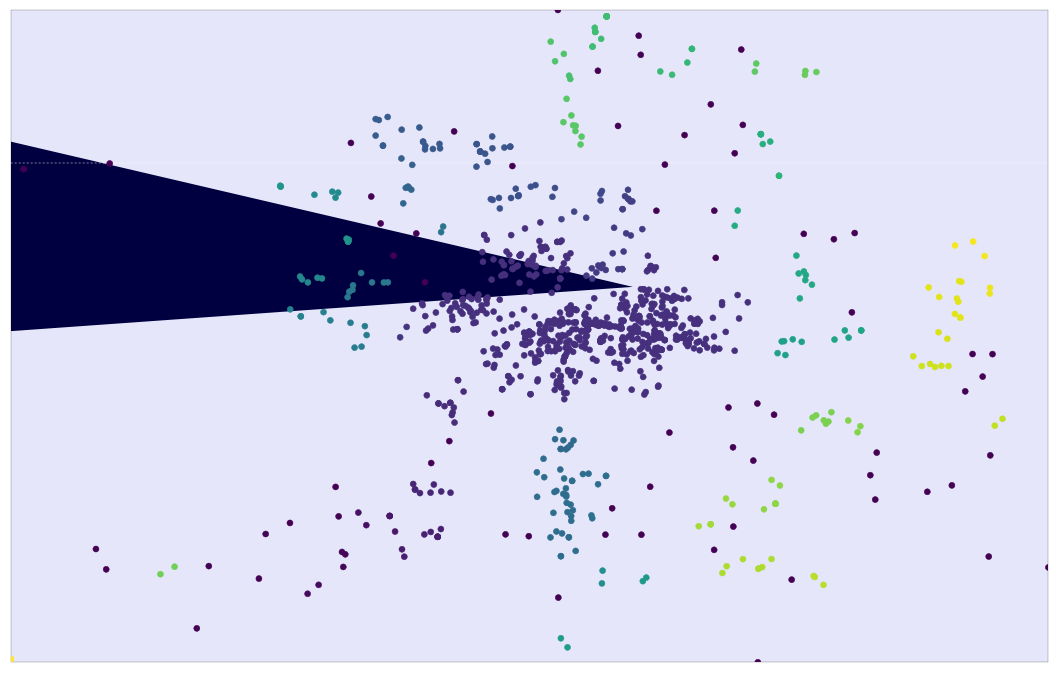

In [139]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(pit_krit_x[:, 0]), urcrnrlat=max(pit_krit_x[:, 0]), llcrnrlon=min(pit_krit_x[:, 1]), urcrnrlon=max(pit_krit_x[:, 1]), resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(pit_krit_x[:, 1], pit_krit_x[:,0], c=pit_krit_y, zorder=10)
    
pl.show()

In [141]:
bai_min_lat, bai_min_lon = 50.976255, 102.987131
bai_max_lat, bai_max_lon = 53.134601, 106.831231


In [142]:
data_bai = data_df[data_df.latitude.between(bai_min_lat, bai_max_lat) &
                   data_df.longitude.between(bai_min_lon, bai_max_lon)]

In [143]:
bai_krit_x = data_bai[['latitude', 'longitude']].values[:1000,]

In [144]:
bai_krit_cl = Clustering(epsilon=10, min_pts=20)
bai_krit_y,bai_krit_x = bai_krit_cl.fit_predict(bai_krit_x)

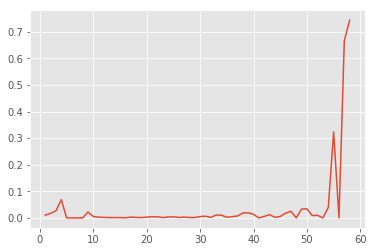

In [145]:
rel_distances = []
for temp_1 in bai_krit_cl.ret_list:
    rel_distances.append (temp_1.rel_distance)
#print rel_distances
pl.plot (rel_distances)

In [151]:
bai_krit_y, bai_krit_x = bai_krit_cl.predict (bai_krit_x, 0.0075)

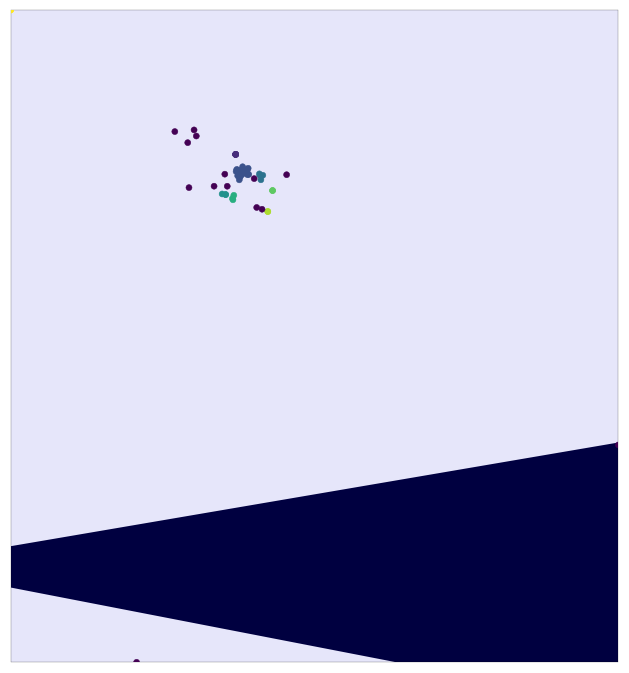

In [152]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(bai_krit_x[:, 0]), urcrnrlat=max(bai_krit_x[:, 0]), llcrnrlon=min(bai_krit_x[:, 1]), urcrnrlon=max(bai_krit_x[:, 1]), resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(bai_krit_x[:, 1], bai_krit_x[:,0], c=bai_krit_y, zorder=10)
    
pl.show()